# Search Parameters

In [1]:
seed = 70 # seed for NMF topic model
num_topics = 12
# query = 'title-abs-key("silk" OR "collagen" AND "biomaterial" AND "molecular dynamics")'
# query = 'title-abs-key("silk" AND "biomaterial" AND "molecular dynamics") AND AUTH("kaplan")'
# query = 'FIRSTAUTH("yeo j. j.")'
# query = 'title-abs-key("gut flora" OR "gut microbiota" OR "intestinal bacteria" AND ("neurotransmitter" OR "serotonin" OR "5-HT" OR "dopamine" OR "norepinephrine" OR "GABA"))'
# query = 'title-abs-key("gut flora" OR "gut microbiota" OR "intestinal bacteria" AND ("mental disorder" OR "mood disorder" OR "depression" OR "major depressive disorder" OR "anxiety" OR "eating disorder"))'
# query = 'title-abs-key("neurotransmitter" AND ("GABA" OR "serotonin" OR "5-HT" OR "dopamine" OR "norepinephrine") AND ("mental health" OR "mental disorder" OR "mood disorder" OR "depression" OR "major depressive disorder" OR "eating disorder" OR "anxiety"))'
# query = 'title-abs-key("gut flora" OR "gut microbiota" OR "intestinal bacteria" AND ("mental health" OR "mental disorder" OR "mood disorder" OR "depression" OR "major depressive disorder" OR "eating disorder" OR "anxiety") AND ("GABA" OR "serotonin" OR "5-HT" OR "dopamine" OR "norepinephrine"))'
# query = 'title-abs-key("deep learning" AND ("autonomous" OR "self-driving" OR "robotic" OR "driverless" AND ("car" OR "cars" OR "driving")))'
# query = 'title-abs-key("autonomous driving" OR "self-driving car" OR "robotic car" OR "driverless car")'

labels = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
vis_seed = 6 # seed for t-SNE visualization
vis_angle = 135 # rotation angle for visualization

# Import Modules

In [2]:
import random
import gensim
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.decomposition
import sklearn.feature_extraction
import ipywidgets as widgets

from wordcloud import WordCloud
from IPython.display import display
from collections import defaultdict

import seaborn as sns
sns.set('paper')

import logging
logging.getLogger().setLevel(logging.INFO)

# some python 3 trickery
import sys
if sys.version_info[0] >= 3:
    unicode = str

import pybliometrics.scopus as scopus


/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
def prepare_fig(w=1, h=None):
    if h is None: h = w
    figsize = (6 * w, 3 * h)
    sns.set(rc={'figure.figsize': figsize})
    fig = plt.figure(figsize=figsize)
    plt.clf()
    return fig

def top_k(mapping, k=10):
    return sorted(mapping.keys(), key=lambda x: mapping[x])[::-1][:k]

pd.set_option('display.max_rows', 250)

# Perform Query

In [4]:
eids = scopus.ScopusSearch(query).get_eids()
random.seed(0)
random.shuffle(eids)

bar = widgets.IntProgress(
    min=0, 
    max=len(eids), 
    description='Loading')
display(bar)

print('query: {} ({} results)'.format(query, len(eids)))

papers = []
for eid in eids:
#    papers.append(scopus.AbstractRetrieval(eid, view='FULL'))
    try:
        papers.append(scopus.AbstractRetrieval(eid, view='FULL'))
    except Exception: 
        pass
    bar.value += 1
    bar.description = str(bar.value)

print('scopus returned {} results'.format(len(papers)))


# Filter on article type
# ar = article, cp = conference proceeding, re = review
print(set([p.srctype for p in papers]))

# Filter on citation type
#papers = [p for p in papers if p.citationType in ('ar', 'cp', 're') or p.citationType is None]

# Filter on date
#papers = [p for p in papers if int(p.coverDate[:4]) <= 2018]

print('{} papers remaining'.format(len(papers)))

IntProgress(value=0, description='Loading', max=1816)

query: title-abs-key("community" AND "participatory" AND "research") AND PUBYEAR AFT 2020 (1816 results)
scopus returned 1816 results
{'j', 'd', 'b', 'k', 'p'}
1816 papers remaining


In [5]:
texts = []
for p in papers:
    text = (p.title or '') + ' ' + (p.abstract or '')
    text = text.lower()
    text = re.sub('[^a-zA-Z0-9]', ' ', text) # Replace punctation by spaces
    texts.append([w for w in text.split(' ') if w]) # Split on spaces, remove empty items

# Analysis

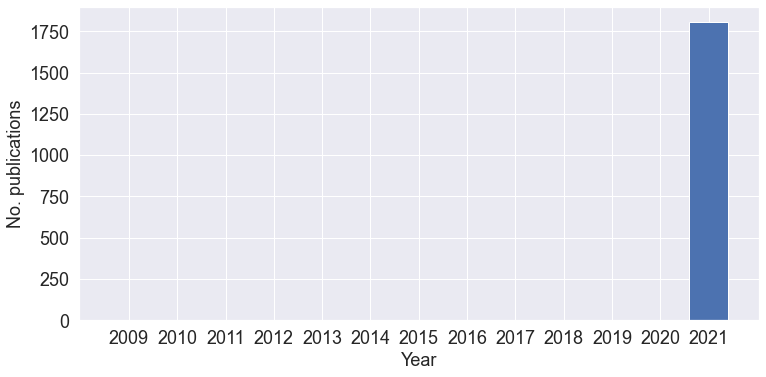

In [6]:
# Publications per year
year_count = defaultdict(int)

for p in papers:
    year_count[int(p.coverDate[:4])] += 1
       
years = range(2009, 2022)

prepare_fig(1.8, 1.8)
plt.ylabel("No. publications",fontsize=18)
plt.xlabel("Year",fontsize=18)
plt.bar(
    years,
    [year_count[y] for y in years])
plt.xticks(years);
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.savefig('years_ad.pdf')

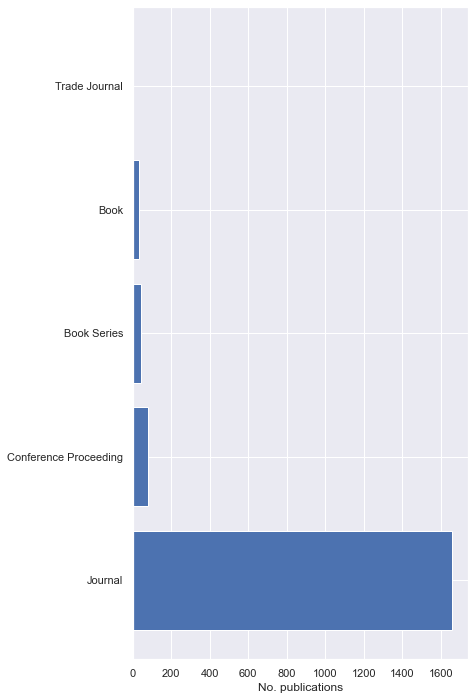

In [7]:
# Publications per aggregation type
def plot_statistic(fun):
    count = defaultdict(int)

    for p in papers:
        for key in fun(p):
            if key:
                count[unicode(key)] += 1

    top_keys = top_k(count, 50)

    prepare_fig(1, 4)
    plt.xlabel("No. publications")
    plt.barh(
        range(len(top_keys)),
        [count[a] for a in top_keys])
    plt.yticks(
        range(len(top_keys)), 
        [key[:50] for key in top_keys])
    plt.show()

plot_statistic(lambda p: [p.aggregationType])

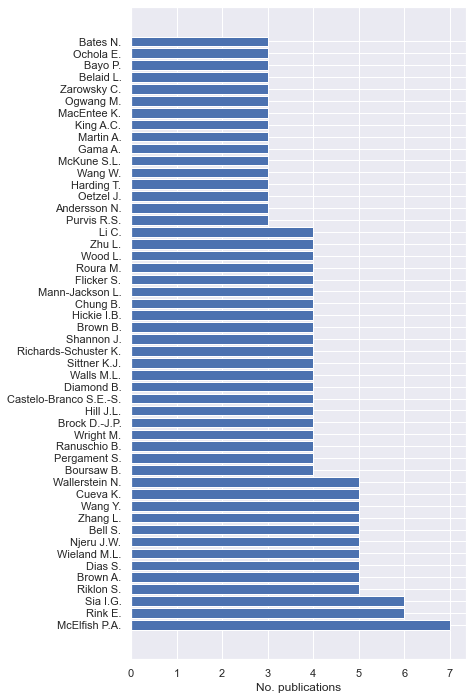

In [8]:
# Publications per author
plot_statistic(lambda p: set(a.indexed_name for a in p.authors or []))

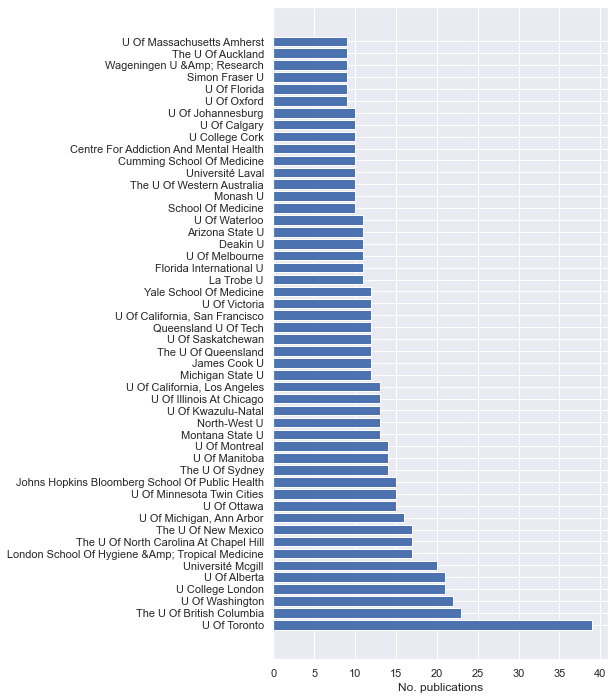

In [9]:
# Publications per institute
def clean_affiliation(name):
    name = unicode(name).title()
    pairs = [
        ['University', 'U'],
        ['Universitat', 'U'],
        ['Laboratories', 'Lab'],
        ['Laboratory', 'Lab'],
        ['National', 'Nat'],
        ['Corporation', 'Corp'],
        ['Technology', 'Tech'],
        ['Institute', 'Inst'],
    ]
    
    for needle, replacement in pairs:
        name = name.replace(needle, replacement)
    return name

plot_statistic(lambda p: set(clean_affiliation(a.name) for a in p.affiliation or []))

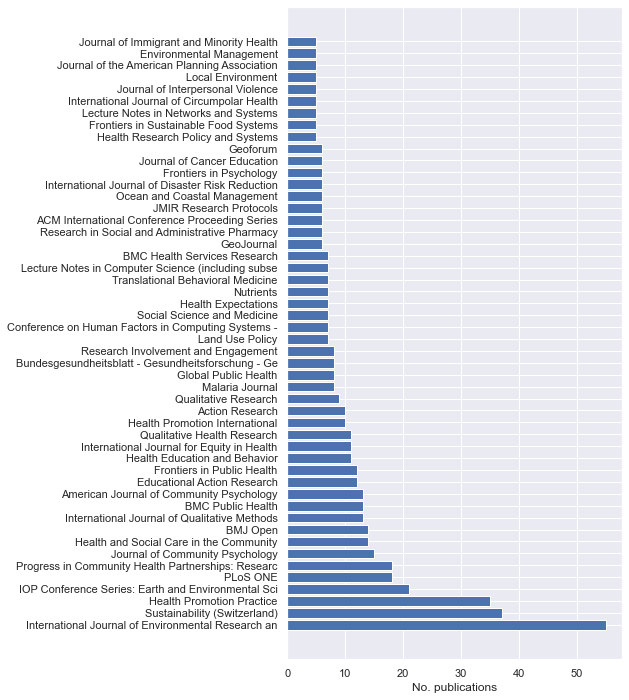

In [10]:
# Publications per publication source, conference/journal (TODO: cleaning!)
plot_statistic(lambda p: [p.publicationName])

# Topic Modeling
## Preprocessing

In [11]:
# Load stopwords, bigrams, and stem rules
try:
    stopwords = set()
    with open('stopwords.txt', 'r') as f:
        stopwords = [w.strip() for w in f if w.strip()]
                
    print('loaded {} stopwords'.format(len(stopwords)))
except Exception as e:
    logging.error('failed to load stopwords.txt: {}'.format(e))

try:
    bigrams = dict()
    with open('bigrams.txt', 'r') as f:
        for line in f:
            if line.strip():
                a, b, c = line.split()
                bigrams[a, b] = c
        
    print('loaded {} bigrams'.format(len(bigrams)))
except Exception as e:
    logging.error('failed to load bigrams.txt: {}'.format(e))
    
try:
    stem_rules = dict()
    with open('stemming.txt', 'r') as f:
        for line in f:
            if line.strip():
                a, b = line.strip().split()
                stem_rules[a] = b
        
    print('loaded {} stem rules'.format(len(stem_rules)))
except Exception as e:
    logging.error('failed to load stemming.txt: {}'.format(e))

loaded 152 stopwords
loaded 42 bigrams
loaded 2 stem rules


In [12]:
# Print common words
one_count = defaultdict(int)

for text in texts:
    for a in text:
        one_count[a] += 1
        
print('Top words')
display(pd.DataFrame(
    [(w, one_count[w], 'Yes' * (w in stopwords)) for w in top_k(one_count, 250)],
    columns=['word', 'count', 'in stopwords.txt?']))

Top words


,word,count,in stopwords.txt?
0,the,21440,Yes
1,and,20341,Yes
2,of,15949,Yes
3,to,11817,Yes
4,in,10789,Yes
5,a,8101,
6,for,4920,Yes
7,community,4288,
8,research,4263,
9,with,3826,Yes


In [13]:
# Print common bigrams
two_count = defaultdict(int)

for text in texts:
    for a, b in zip(text, text[1:]):
        if a not in stopwords and b not in stopwords:
            two_count[a, b] += 1
            
print('Top bigrams')
display(pd.DataFrame(
    [(w, two_count[w], 'Yes' * (w in bigrams)) for w in top_k(two_count, 250)],
    columns=['bigram', 'count', 'in bigrams.txt?']))

Top bigrams


,bigram,count,in bigrams.txt?
0,"(participatory, research)",643,
1,"(action, research)",464,
2,"(a, community)",453,
3,"(author, s)",451,
4,"(participatory, action)",385,
5,"(mental, health)",326,
6,"(a, participatory)",325,
7,"(covid, 19)",300,
8,"(case, study)",221,
9,"(rights, reserved)",213,


In [14]:
# Merge bigrams
for text in texts:
    i = 0
    
    while i < len(text) - 1:
        a, b = text[i], text[i + 1]
        
        if (a, b) in bigrams:
            text[i:i+2] = [bigrams[a,b]]
        else:
            i += 1

In [15]:
# Filter tokens
def filter_texts(texts, f):
    return [[token for token in text if f(token)] for text in texts] 

texts = filter_texts(texts, lambda t: t not in stopwords) # Filter stopwords
texts = filter_texts(texts, lambda t: len(t) > 1) # Remove single char words 
texts = filter_texts(texts, lambda t: not re.match('^[0-9]+$', t)) # Remove numbers

In [16]:
# Stemming
stemmer = gensim.parsing.PorterStemmer()
word_count = defaultdict(int)
stemming = dict()
unstemming = dict()


# Stem each word and count "word, stem" pairs
for text in texts:
    for token in text:
        word_count[token] += 1
    
# Sorted stems by frequency, the value for unstemming[stem] is overwritten 
# and should be the one with the highest count.
for token in sorted(word_count.keys(), key=word_count.get):
    stem = stemmer.stem(token)
    stemming[token] = stem
    unstemming[stem] = token

# Overwrite with user defined rules
for a, b in stem_rules.items():
    stemming[a] = b
    unstemming[b] = b

# Stem words
stemmed_texts = [[unstemming[stemming[token]] for token in text] for text in texts]

logging.info('stemming reduced {} to {} tokens'.format(len(stemming), len(unstemming)))
pd.DataFrame(
    [(
        token, 
        stemming[token], 
        unstemming[stemming[token]], 
        word_count[token]
    ) for token in top_k(word_count, k=250)],
    columns=['Original', 'Stem', 'Unstem', 'Count'])

INFO:root:stemming reduced 18303 to 12255 tokens


,Original,Stem,Unstem,Count
0,community,community,community,4288
1,research,research,research,4263
2,health,health,health,2892
3,participatory,participatori,participatory,2404
4,study,studi,study,1853
5,social,social,social,1547
6,communities,community,community,1414
7,development,develop,development,1019
8,data,data,data,1012
9,methods,method,methods,961


## Create Dictionary

In [17]:
# Remove papers with less than 25 words after preprocessing
n = len(papers)
indices = [i for i in range(len(papers)) if len(stemmed_texts[i]) > 25]
papers = [papers[i] for i in indices]
final_texts = [stemmed_texts[i] for i in indices]

print('papers: {} (removed {})'.format(len(papers), n - len(papers)))

papers: 1767 (removed 49)


In [18]:
dic = gensim.corpora.Dictionary(final_texts)
dic.filter_extremes(0, 0.5) # Remove 
dic.filter_extremes(5, 1)   # 
corpus = [dic.doc2bow(text) for text in final_texts]

print('papers: {}'.format(len(corpus)))
print('dictionary size: {}'.format(len(dic)))

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(12241 unique tokens: ['actors', 'addition', 'adequate', 'affected', 'afloat']...) from 1767 documents (total 265199 corpus positions)
INFO:gensim.utils:Dictionary lifecycle event {'msg': "built Dictionary(12241 unique tokens: ['actors', 'addition', 'adequate', 'affected', 'afloat']...) from 1767 documents (total 265199 corpus positions)", 'datetime': '2021-11-29T13:58:35.437924', 'gensim': '4.0.1', 'python': '3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 15:59:12) \n[Clang 11.0.1 ]', 'platform': 'Darwin-19.6.0-x86_64-i386-64bit', 'event': 'created'}
INFO:gensim.corpora.dictionary:discarding 4 tokens: [('participatory', 1450), ('research', 1593), ('community', 1682), ('study', 1090)]...
INFO:gensim.corpora.dictionary:keeping 12237 tokens which were in no less than 0 and no more than 883 (=50.0%) documents
INFO:gensim.corpora.dictionary:resultin

papers: 1767
dictionary size: 3146


## Topic Modeling

In [19]:
# Create frequency matrix
n, m = len(corpus), len(dic)
matrix = np.zeros((n, m))

for i, row in enumerate(corpus):
    for j, freq in row:
        matrix[i,j] = freq
        

In [20]:
# Run TFIDF model
tfidf_model = sklearn.feature_extraction.text.TfidfTransformer()
tfidf_matrix = tfidf_model.fit_transform(matrix).toarray()

In [21]:
nmf_model = sklearn.decomposition.NMF(
    n_components=num_topics,
    random_state=seed,
    tol=1e-9,
    max_iter=500,
    verbose=True)

# Train model
doc2topic = nmf_model.fit_transform(tfidf_matrix)
topic2token = nmf_model.components_

topic_norm = np.sum(topic2token, axis=1)
topic2token /= topic_norm[:,np.newaxis]
doc2topic *= topic_norm[np.newaxis,:]

doc_norm = np.sum(doc2topic, axis=1)
doc2topic /= doc_norm[:,np.newaxis]

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


violation: 1.0
violation: 0.47084038809717055
violation: 0.314956399425627
violation: 0.21603800456783118
violation: 0.15569221189679622
violation: 0.11761876995791197
violation: 0.09215852351175367
violation: 0.07202197888141071
violation: 0.056783703799587956
violation: 0.045558297485615566
violation: 0.037917583975720384
violation: 0.032719204663388506
violation: 0.030088797723479457
violation: 0.028681502412218774
violation: 0.027952954709112028
violation: 0.027599043314388325
violation: 0.027461641933822736
violation: 0.02734478640939559
violation: 0.027219818800854185
violation: 0.026933646470223765
violation: 0.026394841993384856
violation: 0.025574344468357116
violation: 0.02449843191380514
violation: 0.023284145099805465
violation: 0.021885589607895776
violation: 0.019885594411446817
violation: 0.018208275335373437
violation: 0.01671488753506908
violation: 0.015373094045827198
violation: 0.01426064324400086
violation: 0.013317684693280643
violation: 0.012479315573592765
violat

violation: 1.9837612763510724e-06
violation: 1.909926760027707e-06
violation: 1.8388836633130035e-06
violation: 1.7705235479349457e-06
violation: 1.7047496626361752e-06
violation: 1.6414599487301952e-06
violation: 1.5805694063322706e-06
violation: 1.5219834973205846e-06
violation: 1.4656170656381182e-06
violation: 1.4113675981922286e-06
violation: 1.3591578952710758e-06
violation: 1.3089045453635367e-06
violation: 1.260536639190792e-06
violation: 1.2139831206205297e-06
violation: 1.1691724096538338e-06
violation: 1.126046022533116e-06
violation: 1.0845428049336277e-06
violation: 1.0445844344525612e-06
violation: 1.0061151097063142e-06
violation: 9.690801273337155e-07
violation: 9.334203780889939e-07
violation: 8.990865766468918e-07
violation: 8.660176074748254e-07
violation: 8.341913444258849e-07
violation: 8.035526507671125e-07
violation: 7.74056681687056e-07
violation: 7.456584694669908e-07
violation: 7.183120024560102e-07
violation: 6.919753053158149e-07
violation: 6.666149045647567

In [22]:
rows = []

for label, vec in zip(labels, topic2token):
    rows.append([label] + ['{} ({:.2})'.format(dic[i], vec[i]) for i in np.argsort(vec)[::-1][:10]])

# Each row is a topic, columns are words ordered by weight 
pd.DataFrame(rows)

,0,1,2,3,4,5,6,7,8,9,10
0,A,social (0.011),engagement (0.0094),practice (0.0083),action (0.007),project (0.0066),collaborative (0.0063),participants (0.0063),ethical (0.0059),arts (0.0056),process (0.0056)
1,B,health (0.066),mental (0.015),covid (0.012),promote (0.0085),cbpr (0.0079),pandemic (0.0076),refugee (0.0066),public (0.0064),disparities (0.0064),partnership (0.0063)
2,C,school (0.058),students (0.045),education (0.033),teachers (0.022),learning (0.019),teaching (0.011),classroom (0.0073),practice (0.007),inclusive (0.0068),par (0.0066)
3,D,intervention (0.027),children (0.018),parents (0.017),program (0.012),implementation (0.0073),group (0.0064),child (0.0063),family (0.0062),evaluation (0.006),design (0.0059)
4,E,youth (0.099),young (0.018),ypar (0.0096),substance (0.0088),people (0.0086),action (0.008),adolescents (0.0072),voices (0.0067),program (0.0066),engagement (0.0064)
5,F,indigenous (0.076),cultural (0.018),aboriginal (0.015),knowledge (0.012),people (0.009),western (0.0064),elders (0.0062),traditional (0.0058),canada (0.0057),land (0.0053)
6,G,care (0.028),patients (0.019),services (0.015),healthcare (0.0098),medical (0.009),women (0.0087),cancer (0.0083),people (0.0079),participants (0.0071),homelessness (0.0068)
7,H,food (0.098),insecurity (0.015),security (0.013),nutrition (0.013),system (0.0097),healthy (0.0091),de (0.0079),household (0.0073),la (0.0068),environment (0.0067)
8,I,hiv (0.062),men (0.02),women (0.02),aids (0.013),msm (0.012),resilience (0.012),sexual (0.011),sex (0.01),living (0.0094),stigma (0.009)
9,J,urban (0.035),citizen (0.024),city (0.019),planning (0.015),design (0.014),technology (0.0095),process (0.0082),science (0.0082),digital (0.0068),tools (0.0066)


Topic 0 (A)
Topic 1 (B)
Topic 2 (C)
Topic 3 (D)
Topic 4 (E)
Topic 5 (F)
Topic 6 (G)
Topic 7 (H)
Topic 8 (I)
Topic 9 (J)
Topic 10 (K)
Topic 11 (L)


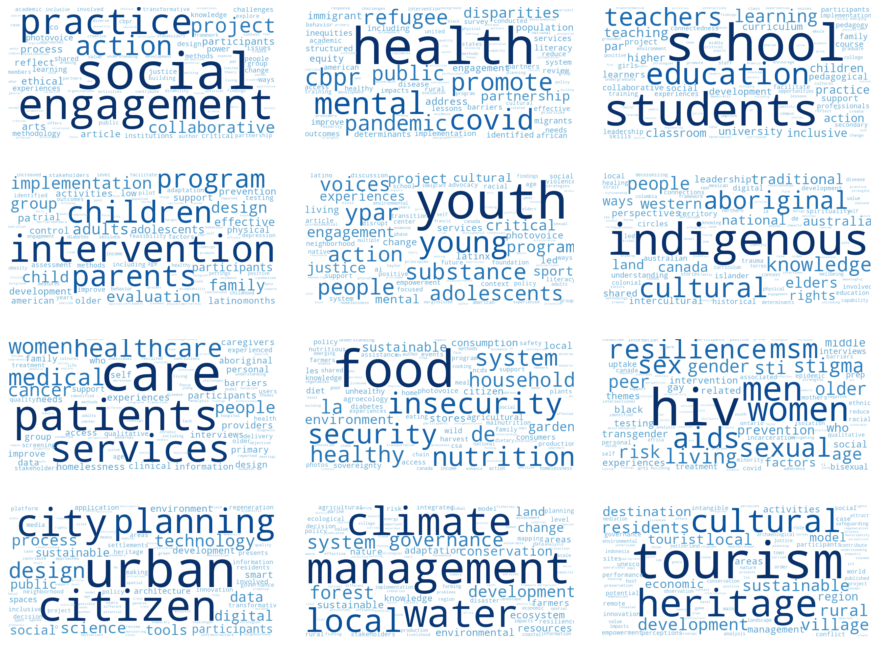

In [23]:
prepare_fig(2, 3)
for index in range(num_topics):
    mapping = dict()
    for i in np.argsort(topic2token[index])[::-1][:100]:
        if topic2token[index,i] > 0:
            mapping[dic[i]] = topic2token[index,i]
    
    def get_color(word, **kwargs):
        weight = kwargs['font_size'] / 60.0 * 0.6 + 0.4
        r, g, b = plt.get_cmap('Blues')(weight)[:3]
        return 'rgb(%s, %s, %s)' % (int(r * 255), int(g * 255), int(b * 255))
    
    wc = WordCloud(
        prefer_horizontal=True,
        max_font_size=75,
        #width=395,
        #height=250,
        scale=2,
        background_color='white', 
        color_func=get_color, 
        relative_scaling=0.5)
    wc.fit_words(mapping)
    
    print('Topic {} ({})'.format(index, labels[index]))
    plt.subplot(4, 3, index + 1)
    plt.imshow(wc.to_array(), interpolation='bilinear')
    plt.xticks([])
    plt.yticks([])
    
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.1, hspace=0.1)
plt.show()


## Visualization

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 1767 samples in 0.000s...
[t-SNE] Computed neighbors for 1767 samples in 0.104s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1767
[t-SNE] Computed conditional probabilities for sample 1767 / 1767
[t-SNE] Mean sigma: 0.084365
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.548325
[t-SNE] KL divergence after 1000 iterations: 1.200318


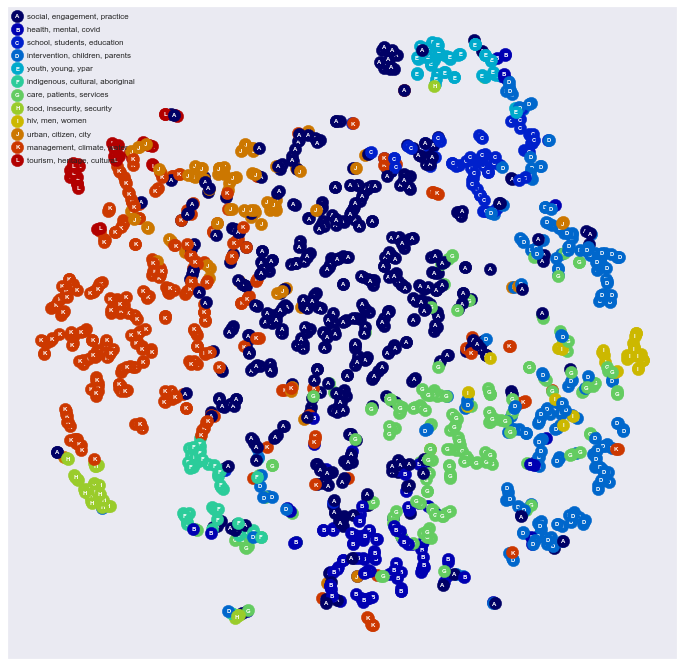

In [24]:
import sklearn.manifold
import sklearn.metrics.pairwise
from sklearn.decomposition import TruncatedSVD

def draw_dot(p, t, zorder=0):
    color = plt.get_cmap('jet')(float(t) / num_topics)
    color = 0.8 * np.array(color)[:3]
    
    plt.scatter(
        p[0], 
        p[1],
        s=150,
        c=[color],
        marker='o',
        linewidth=0.5,
        zorder=zorder)
    
    plt.text(
        p[0], 
        p[1],
        labels[t],
        fontsize=6,
        color='1',
        va='center',
        ha='center',
        fontweight='bold',
        zorder=zorder + 1)

# Lower dimensionality of original frequency matrix to improve cosine distances for visualization
reduced_matrix = TruncatedSVD(
    n_components=10, 
    random_state=seed
).fit_transform(tfidf_matrix)

# Learn model, tune perplexity value according to complexity of data
model = sklearn.manifold.TSNE(
    verbose=True,
    metric='cosine',
    random_state=vis_seed,
    perplexity=5)
pos = model.fit_transform(reduced_matrix)

# Rotate visualization
theta = np.deg2rad(vis_angle + 60)
R = np.array([[np.cos(theta), np.sin(theta)], 
              [-np.sin(theta), np.cos(theta)]])
pos = np.dot(pos, R)

# Resize so xy-position is between 0.05 and 0.95
pos -= (np.amin(pos, axis=0) + np.amax(pos, axis=0)) / 2
pos /= np.amax(np.abs(pos))
pos = (pos * 0.5) + 0.5
pos = (pos * 0.9) + 0.05

prepare_fig(2, 4)
plt.xticks([])
plt.yticks([])
plt.xlim(0, 1)
plt.ylim(0, 1)
zorder = 0

# Draw dots
for i in np.random.permutation(len(doc2topic)):
    topic_id = np.argmax(doc2topic[i])
    draw_dot(pos[i], topic_id, zorder)
    zorder += 2

# Draw legend
for i in range(num_topics):    
    y = 0.985 - i * 0.02
    label = ', '.join(dic[w] for w in np.argsort(topic2token[i])[::-1][:3])

    draw_dot([0.015, y], i)
    plt.text(0.03, y, label, ha='left', va='center', fontsize=8, zorder=zorder)
    zorder += 1

plt.show()

In [25]:
def on_select(i):
    p = papers[i]
    print(p.title)
    
    prepare_fig(1, 2)
    plt.xticks([])
    plt.yticks([])
    plt.scatter(pos.T[0], pos.T[1], c='.5')
    plt.scatter(pos[i,0], pos[i,1], c='0', marker='x')
    plt.show()

    top_words = np.argsort(topic2token, axis=1)[:,::-1]
    ticks = ['{} ({})'.format(l, ', '.join(dic[v] for v in w[:3])) for l, w in zip(labels, top_words)]
    
    fig = prepare_fig(1, 2)
    plt.barh(range(num_topics), doc2topic[i])
    plt.xlim(0, 1)
    plt.ylim(num_topics, -1)
    plt.yticks(range(num_topics), ticks)
    plt.show()
    
    print(p.abstract)

options = sorted([((p.title or '').strip()[:50], i) for i, p in enumerate(papers)])
widget = widgets.interactive(on_select, i=options)
widget.children[-1].layout.height = '2000px'
widget

interactive(children=(Dropdown(description='i', options=(('"A Return to and of the Land": Indigenous Knowledg'…